# XGBoost

In astrophysics, a crucial challenge is determining the distance of objects from Earth. We can't directly measure these distances, so we rely on the light emitted by these objects that reaches Earth. We use a parameter called "redshift" (z) to estimate these distances. Essentially, the greater the redshift, the farther the object is from Earth. We can measure redshift accurately by analyzing the spectrum of light from the object.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor


# Data

### Load data

In [4]:
# Load data from quasars.csv
# The file has 11 columns: first 10 are features (x1-x10), last column is target (y)
data = pd.read_csv(
    "quasars.csv",
    header=None,
    sep=",",
)

# Split into features and target
X_data = data.iloc[:, :10]  # First 10 columns (x1 to x10)
y_data = data.iloc[:, 10:11]  # Last column (y)

labels = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10"]
# Set column names for clarity
X_data.columns = labels
y_data.columns = ["y"]

print("X_data - shape:", X_data.shape)
print("y_data - shape:", y_data.shape)
print("\nFirst few rows of X_data:")
print(X_data.head())
print("\nFirst few rows of y_data:")
print(y_data.head())

X_data - shape: (20000, 10)
y_data - shape: (20000, 1)

First few rows of X_data:
          x1         x2         x3         x4         x5         x6  \
0  21.438610  19.551710  18.458599  18.002470  17.684971  20.114059   
1  22.314270  21.104860  21.004841  21.159269  20.946699  18.455139   
2  23.585871  21.433531  20.224360  19.816570  19.820490  23.784389   
3  19.402540  17.313789  16.431690  16.170959  16.002871  19.418880   
4  21.115400  20.218599  19.658670  19.515110  19.455120  21.103861   

          x7         x8         x9        x10  
0  18.123720  16.970390  16.529791  16.130140  
1  17.081511  16.702650  16.831730  16.627399  
2  21.429319  20.209129  19.806770  19.804779  
3  17.314190  16.453730  16.165510  15.996530  
4  20.175430  19.659109  19.522350  19.480000  

First few rows of y_data:
          y
0  0.147575
1  0.014620
2 -0.000360
3  0.000040
4  0.000317


In [5]:
# Display basic statistics about the data
print("Data types:")
print(X_data.dtypes)
print("\nTarget variable statistics:")
print(y_data.describe())

Data types:
x1     float64
x2     float64
x3     float64
x4     float64
x5     float64
x6     float64
x7     float64
x8     float64
x9     float64
x10    float64
dtype: object

Target variable statistics:
                  y
count  20000.000000
mean       0.354180
std        0.644657
min       -0.007470
25%        0.000166
50%        0.117609
75%        0.463949
max        7.009400


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>,
        <Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>,
        <Axes: title={'center': 'x5'}>],
       [<Axes: title={'center': 'x6'}>, <Axes: title={'center': 'x7'}>,
        <Axes: title={'center': 'x8'}>, <Axes: title={'center': 'x9'}>,
        <Axes: title={'center': 'x10'}>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

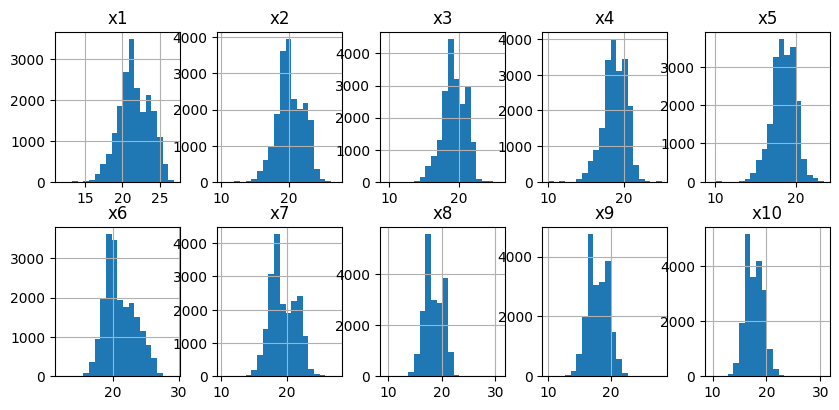

In [6]:
# Gussian / Normal Distribution
X_data.hist(figsize=(10, 7), layout=(3, 5), bins=20, column=labels)


0.0    6991
1.0    3009
Name: y, dtype: int64 
 0.0    69.91
1.0    30.09
Name: y, dtype: float64


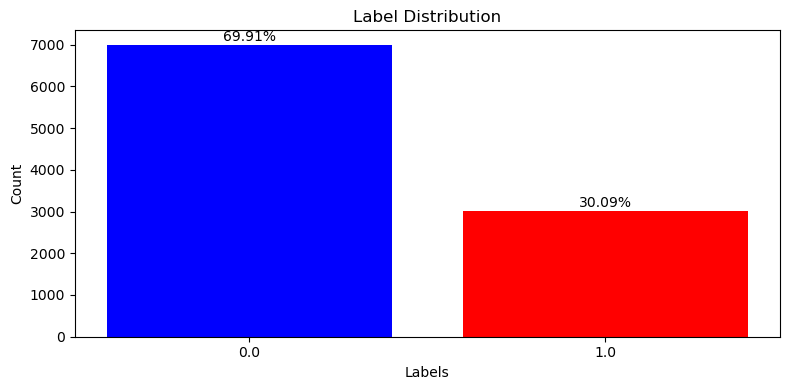

In [ ]:
label_counts = y_data["y"].value_counts()
label_percentages = y_data["y"].value_counts(normalize=True) * 100
colors = ["blue", "red"]

print(label_counts, "\n", label_percentages)

# Create a bar plot with counts on x-axis and percentages as labels
fig, ax = plt.subplots(figsize=(8, 4))

bars = ax.bar(label_counts.index.astype(str), label_counts.values, color=colors)
ax.set_xlabel("Labels")
ax.set_ylabel("Count")
ax.set_title("Label Distribution")

# Add percentage labels above the bars
for bar, percentage in zip(bars, label_percentages):
    height = bar.get_height()
    ax.annotate(
        f"{percentage:.2f}%",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset
        textcoords="offset points",
        ha="center",
    )

plt.tight_layout()
plt.show()

In [ ]:
# Already Normalized, close to zero mean and unit variance
print("Mean:")
print(X_data.mean().mean())

print("Standard Variance:")
print(X_data.std().mean())


Mean:
-0.008624957933487016
Standard Variance:
2.3143824088571243


### Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Baseline model

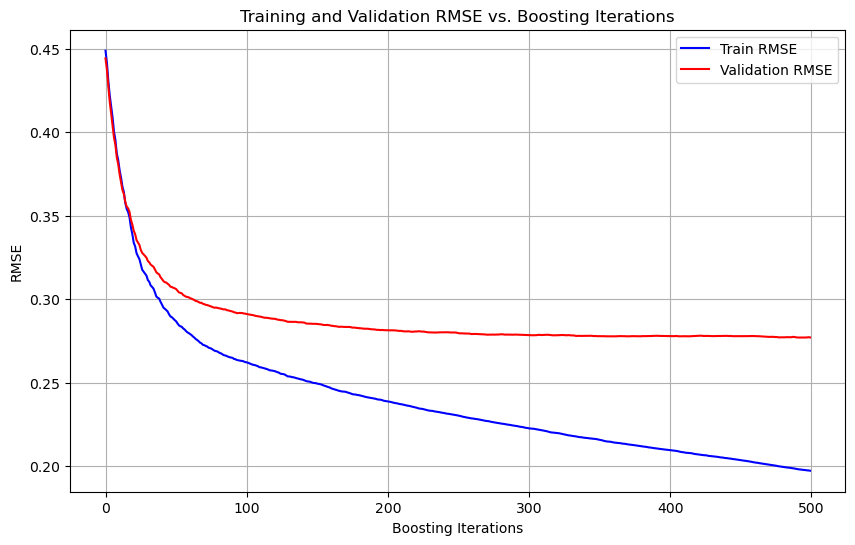

In [ ]:
warnings.filterwarnings("ignore")
# XGBoost classifier

### Initialize
# Use XGBoost's DMatrix object to store the feature and target data
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

evals_result = {}
params = {
    "colsample_bytree": 0.5,
    "learning_rate": 0.1,
    "max_depth": 4,
    "reg_lambda": 1,
    "n_estimators": 500,
    "eval_metric": "rmse",  # Use RMSE as evaluation metric
}

### Train
""" 
    colsample_bytree: 0.5 -  the fraction of features to be randomly sampled when constructing each decision tree
    learning_rate: 0.1 - step size shrinkage used to prevent overfitting
    max_depth: 4 - the maximum depth of each tree
    reg_lambda: 1 - L2 regularization term on weights
    n_estimators: 500 - number of trees we want to build
"""
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dval, "val")],
    evals_result=evals_result,
    verbose_eval=False,
)

# Get the training and validation RMSE
train_rmse = evals_result["train"]["rmse"]
val_rmse = evals_result["val"]["rmse"]

# Plot the training and validation RMSE
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label="Train RMSE", color="blue")
plt.plot(val_rmse, label="Validation RMSE", color="red")
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.title("Training and Validation RMSE vs. Boosting Iterations")
plt.grid(True)
plt.show()


In [ ]:
# Make predictions on both train and val datasets
y_train_pred = model.predict(dtrain)
y_val_pred = model.predict(dval)

# Compute evaluation metrics
train_accuracy = accuracy_score(y_train, np.round(y_train_pred))
val_accuracy = accuracy_score(y_val, np.round(y_val_pred))

train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)

train_rmse = np.sqrt(train_mse)
val_rmse = np.sqrt(val_mse)

# Calculate R-squared (R2) score
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Create a matrix-like representation of scores
score_matrix = [
    ["Metric", "Train Score", "Validation Score"],
    ["Accuracy", train_accuracy, val_accuracy],
    ["MSE", train_mse, val_mse],
    ["RMSE", train_rmse, val_rmse],
    ["R2 Score", train_r2, val_r2],
]

# Display the score matrix
first = True
for row in score_matrix:
    if first:
        first = False
    else:
        row[1:] = [round(float(elm), 4) for elm in row[1:]]
    print("{:<15} {:<15} {:<15}".format(*row))

# Score on test set
dtest = xgb.DMatrix(X_test, label=y_test)
y_test_pred = model.predict(dtest)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)
print("\nTesting scores:")
print("Test RMSE: {:.4f}".format(test_rmse))
print("Test R2: {:.4f}".format(test_r2))

Metric          Train Score     Validation Score
Accuracy        0.9643          0.8962         
MSE             0.0389          0.0768         
RMSE            0.1972          0.2771         
R2 Score        0.8148          0.6252         

Testing scores:
Test RMSE: 0.2868
Test R2: 0.6151


# Gridsearch

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define your parameter grid for grid search
param_grid = {
    "colsample_bytree": [0.3, 0.5, 0.7],
    "learning_rate": [0.1, 0.01, 0.001],
    "max_depth": [3, 4, 5, 6],
    "reg_lambda": [0.1, 1.0, 10.0],
    "n_estimators": [100, 500, 1000],
}

xgb_reg = xgb.XGBRegressor(eval_metric="rmse")

grid_search = GridSearchCV(
    estimator=xgb_reg, param_grid=param_grid, scoring="neg_mean_squared_error", cv=3
)

# Fit the grid search to the validation data
grid_search.fit(X_val, y_val)  # Assuming X_val and y_val are your validation data

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
# Create a final model with the best parameters and train on the training data
final_model = xgb.XGBRegressor(**best_params, eval_metric="rmse")
final_model.fit(X_train, y_train)  # Assuming X_train and y_train are your training data


In [109]:
y_pred = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2 Score:", r2)

# KNN - comparison

In [ ]:
# Create a KNN regressor with k=5
knn_model = KNeighborsRegressor(n_neighbors=5)

# Train the KNN model on your training data
knn_model.fit(X_train, y_train)  # Assuming X_train and y_train are your training data

# Make predictions on the test data
y_pred_knn = knn_model.predict(X_test)  # Assuming X_test is your test data

# Calculate RMSE
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))

# Calculate R-squared (R2) score
r2_knn = r2_score(y_test, y_pred_knn)

print("KNN RMSE:", rmse_knn)
print("KNN R2 Score:", r2_knn)

KNN RMSE: 0.2734593205579214
KNN R2 Score: 0.6500861565745127
